In [1]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
from sklearn.externals import joblib
%matplotlib inline
nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/stephengriggs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv("data/labeled_data.csv")

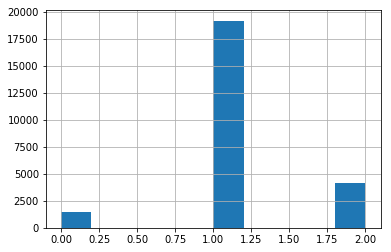

In [3]:
df['class'].hist()

In [4]:
tweets=df.tweet

In [5]:
stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [6]:
baseline_tfidf = joblib.dump(vectorizer, "models/baseline_tfidf.joblib")

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'e', 'f', 'g', 'h', 'j', 'l', 'n', 'p', 'r', 'u', 'v', 'w'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [47]:
print(tfidf)

[[1.29163073 0.         0.         ... 0.         0.         0.        ]
 [2.58326146 0.         0.         ... 0.         0.         0.        ]
 [2.58326146 0.         0.         ... 0.         0.         0.        ]
 ...
 [1.29163073 0.         0.         ... 0.         0.         0.        ]
 [1.29163073 0.         0.         ... 0.         0.         0.        ]
 [2.58326146 0.         0.         ... 0.         0.         0.        ]]


In [48]:
baseline_idf = joblib.dump(idf_vals[ngram_indices], "models/baseline_idf.joblib")

NameError: name 'ngram_indices' is not defined

In [11]:
#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [12]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

baseline_pos = joblib.dump(vectorizer, "models/baseline_pos.joblib")

In [13]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [14]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [15]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [16]:
feats = get_feature_array(tweets)

In [17]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [18]:
M.shape

(24783, 4023)

In [19]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

In [20]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [22]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [23]:
pipe = Pipeline(
        [('select', SelectFromModel(LogisticRegression(class_weight='balanced',
                                                  penalty="l1", C=0.01))),
        ('model', LogisticRegression(class_weight='balanced',penalty='l2'))])

In [24]:
param_grid = [{}] # Optionally add parameters here

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=2)

In [25]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................................................. , total=   5.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] ................................................. , total=   7.0s
[CV]  ................................................................
[CV] ................................................. , total=   5.8s
[CV]  ................................................................
[CV] ................................................. , total=  10.0s
[CV]  ................................................................
[CV] ................................................. , total=   6.6s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.2s finished


In [26]:
y_preds = model.predict(X_test)

In [27]:
report = classification_report( y_test, y_preds )

In [28]:
print(report)

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       164
           1       0.93      0.87      0.90      1905
           2       0.67      0.79      0.73       410

   micro avg       0.83      0.83      0.83      2479
   macro avg       0.66      0.71      0.68      2479
weighted avg       0.85      0.83      0.84      2479



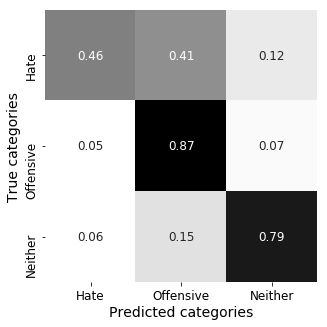

In [29]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

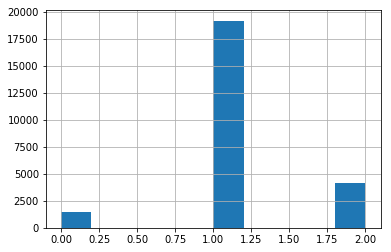

In [30]:
#True distribution
y.hist()

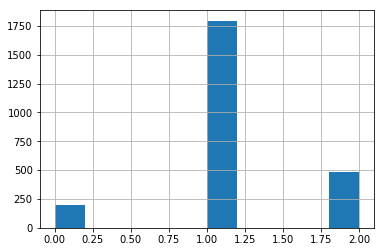

In [31]:
pd.Series(y_preds).hist()

## Saving the model

In [32]:
# Saving with pickle
filename_p = "models/base_model_pickle.pkl"
pickle.dump(model.best_estimator_, open(filename_p,'wb'))

In [33]:
filename1 = "models/base_model.pkl"
filename2 = "models/base_model.joblib"

In [34]:
# Saving with joblib
joblib.dump(model.best_estimator_, filename1)
joblib.dump(model.best_estimator_, filename2)

['models/base_model.joblib']

In [35]:
type(model.best_estimator_)

sklearn.pipeline.Pipeline

## Loading the models

In [36]:
loaded_model = joblib.load(filename1)
test2 = loaded_model.predict(X_test)
report2 = classification_report( y_test, test2 )
loaded_model = joblib.load(filename1)
print(report2)

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       164
           1       0.93      0.87      0.90      1905
           2       0.67      0.79      0.73       410

   micro avg       0.83      0.83      0.83      2479
   macro avg       0.66      0.71      0.68      2479
weighted avg       0.85      0.83      0.84      2479



In [37]:
loaded_model2 = joblib.load(filename2)
test3 = loaded_model2.predict(X_test)
report3 = classification_report( y_test, test3 )
print(report3)

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       164
           1       0.93      0.87      0.90      1905
           2       0.67      0.79      0.73       410

   micro avg       0.83      0.83      0.83      2479
   macro avg       0.66      0.71      0.68      2479
weighted avg       0.85      0.83      0.84      2479



In [38]:
loaded_pkl = pickle.load(open(filename_p, 'rb'))
test4 = loaded_pkl.predict(X_test)
report4 = classification_report( y_test, test4 )
print(report4)

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       164
           1       0.93      0.87      0.90      1905
           2       0.67      0.79      0.73       410

   micro avg       0.83      0.83      0.83      2479
   macro avg       0.66      0.71      0.68      2479
weighted avg       0.85      0.83      0.84      2479

